In [336]:
import torch
import torchvision
import torchvision.transforms as transforms
import skimage.io as skio
from torch import nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torchmetrics import PeakSignalNoiseRatio

path = 'lion_orig.png'
img = skio.imread(path)

In [318]:
configs = {
    'lr': .0001,
    'bs': 128,
    'epochs': 2000
}

In [539]:
def inp_mapping(v, B, no=False):
    if no:
        return v
    x_proj = 2 * np.pi * v @ B.T
    return np.concatenate([np.sin(x_proj), np.cos(x_proj)], axis=1)

In [536]:
class MLP(nn.Module):
    def __init__(self, input_n=2, num_layers=3, num_channels=256, enc=lambda x: basic(x)):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers += [nn.Linear(input_n, num_channels), nn.ReLU()]
        for _ in range(num_layers):
            self.layers += [nn.Linear(num_channels, num_channels)]
            self.layers += [nn.ReLU()]
        self.layers += [nn.Linear(num_channels, num_layers)]
        self.layers += [nn.Sigmoid()]
        self.enc = enc
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

def render(model, x_train):
    output = model(torch.tensor(x_train, dtype=torch.float).cuda()).detach().cpu().numpy()
    return output.reshape(img.shape)
    
def train(model, criterion, optimizer, configs, x_train, target_train, x_test, target_test):
    psnr_test = []
    psnr_train = []
    for epoch in range(configs['epochs']):
        inputs = x_train
        optimizer.zero_grad()
        outputs = model(inputs)
        recon = outputs.reshape(target_train.shape)
        loss = criterion(recon, target_train)
        loss.backward()
        optimizer.step()
        psnr_train += [psnr(torch.tensor(recon.detach().cpu().numpy()), torch.tensor(target_train.detach().cpu().numpy())).item()]
        # test
        with torch.no_grad():
            inputs = x_test
            outputs = model(inputs)
            recon, t = model(x_test).reshape(target_test.shape).detach().cpu().numpy(), target_test.detach().cpu().numpy()
            psnr_val = psnr(torch.tensor(recon), torch.tensor(t))
            psnr_test += [psnr_val.item()]
            if epoch % 200 == 0:
                fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
                ax1.imshow(t)
                ax2.imshow(recon)
                plt.show()
                print('PSNR:', psnr_val)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12, 6))
    ax1.plot(range(len(psnr_train)), psnr_train)
    ax2.plot(range(len(psnr_test)), psnr_test)
    return

In [548]:
psnr = PeakSignalNoiseRatio()
coords = np.linspace(0, img.shape[0], img.shape[0], endpoint=False)
B = np.random.normal(0, 1, size=(128, 2))
no = False

x_test = np.stack(np.meshgrid(coords, coords), -1)[1::2, 1::2, :]
x_test = inp_mapping(x_test.reshape(x_test.shape[0] ** 2, 2)/(2*x_test.shape[0]), B, no=no)
x_test = torch.tensor(x_test, dtype=torch.float)
x_test = x_test.cuda()
target_test = torch.tensor(img[1::2, 1::2, :]/255., dtype=torch.float).cuda()

x_train = np.stack(np.meshgrid(coords, coords), -1)[::2, ::2, :]
x_train = inp_mapping(x_train.reshape(x_train.shape[0] ** 2, 2)/(2*x_train.shape[0]), B, no=no)
x_train = torch.tensor(x_train, dtype=torch.float)
x_train = x_train.cuda()
target_train = torch.tensor(img[::2, ::2, :]/255., dtype=torch.float).cuda()

model = MLP(input_n=len(x_train[0]), enc=basic).cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=configs['lr'])

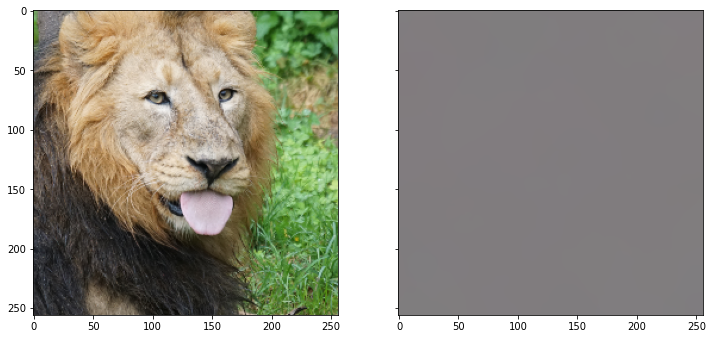

PSNR: tensor(12.2225)


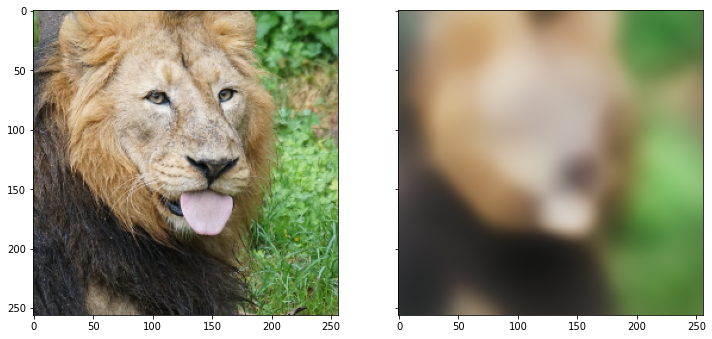

PSNR: tensor(19.4089)


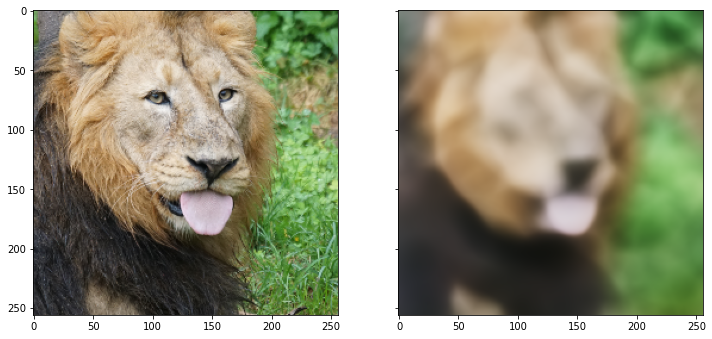

PSNR: tensor(20.9119)


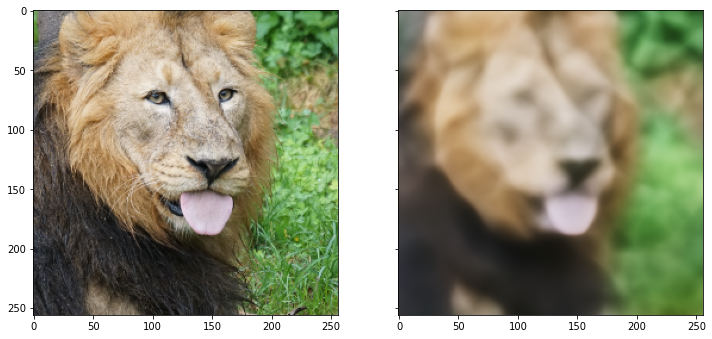

PSNR: tensor(21.6610)


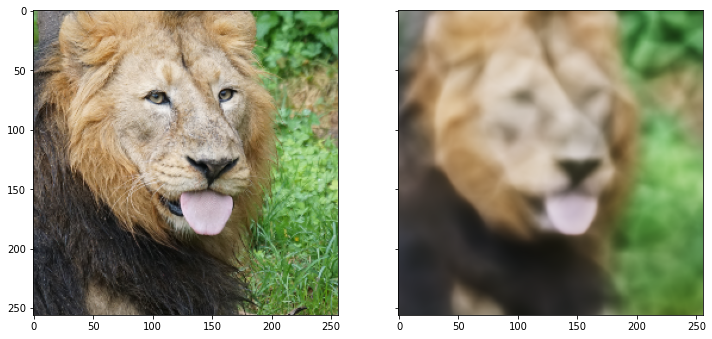

PSNR: tensor(22.0954)


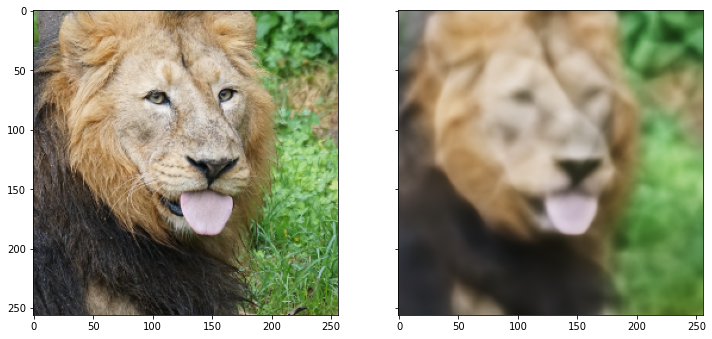

PSNR: tensor(22.3493)


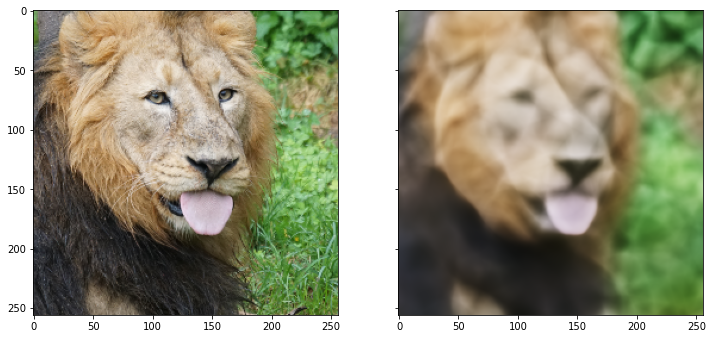

PSNR: tensor(22.5576)


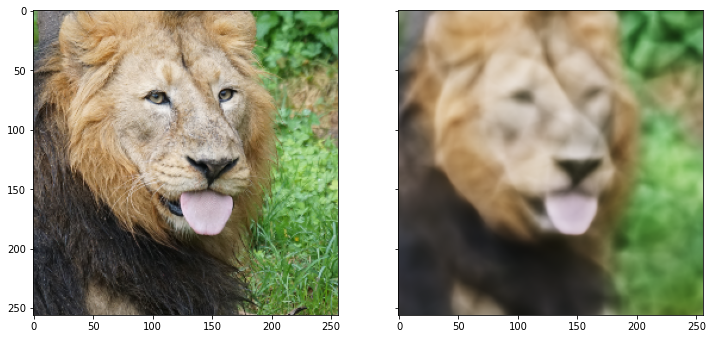

PSNR: tensor(22.7091)


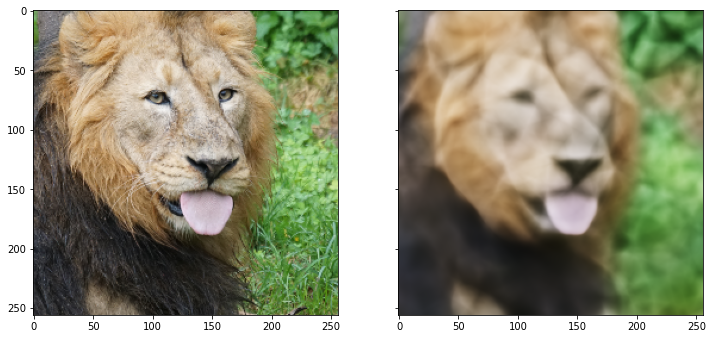

PSNR: tensor(22.8234)


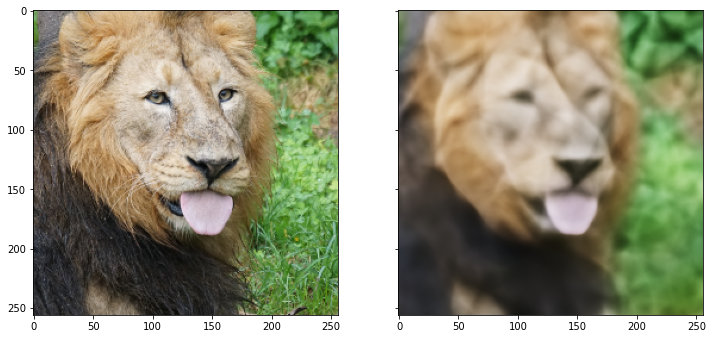

PSNR: tensor(22.9358)


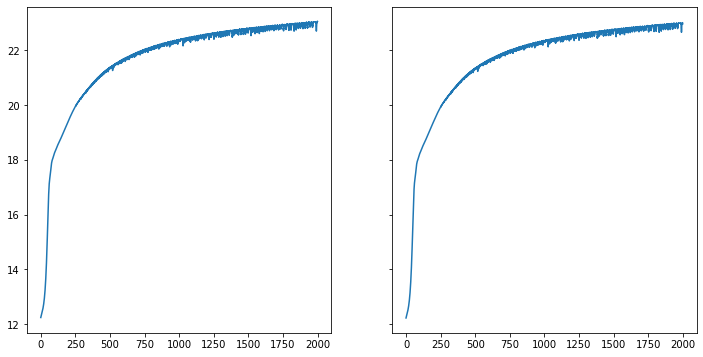

In [549]:
train(model, criterion, optimizer, configs, x_train, target_train, x_test, target_test)